## Assignment 12

# Joint assimilation of navigation data coming from different sources

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of this laboratory work is to develop a navigation filter by assimilating data coming from different sources. Important outcome of this exercise is getting skill to incorporate all available measurement information into assimilation algorithm and develop a tracking filter for nonlinear models.**

In [2]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# plot graphs

def showPlease(arr,legend = [],xlabel ="x",ylabel="y",title="title"):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

**In this assignment we work again with object motion disturbed by normally distributed random acceleration. Firsty we define a true trajectory, introducing initial conditions.**

In [4]:
def true_traj(n, T, x_0, y_0, v_x_0, v_y_0, σ_a):
    x = np.array([x_0])
    y = np.array([y_0])
    v_x = np.array([v_x_0])
    v_y = np.array([v_y_0])
    a_x = np.random.normal(0, σ_a, n-1)
    a_y = np.random.normal(0, σ_a, n-1)
    for i in range(n-1):
        
        x = np.append(x, (x[i] + v_x[i] * T + 
                          a_x[i] * T ** 2 / 2))
        v_x = np.append(v_x, (v_x[i] + a_x[i] * T))
        
        y = np.append(y, (y[i] + v_y[i] * T + 
                          a_y[i] * T ** 2 / 2))
        v_y = np.append(v_y, (v_y[i] + a_y[i] * T))
    
    return np.array([x, v_x, y, v_y])

In [5]:
# size of trajectory
n = 500

# interval between measurements
T = 2

# initial coordinates 
x_0 = 1000
y_0 = 1000

# initial components of velocity
v_x_0 = 100
v_y_0 = 100

# variance of noise for acceleration's projections on both axes
σ_a = 0.3

# introducing the trajectory X
X = true_traj(n, T, x_0, y_0, v_x_0, v_y_0, σ_a)

**Then we obtain true values of range D and azimuth β – polar coordinates from Cartesian ones using conversion formulas.**

In [6]:
def polar(x, y):
    xx = x.copy()
    yy = y.copy()
    D = (xx ** 2 + yy ** 2) ** 0.5
    β = np.arctan(xx / yy)
    return D, β

In [7]:
D, β = polar(X[0], X[2])

**Next we generate the measurements of range and azimuth provided by the first observer. Again, we do not perform any transformation of measurements (between polar and Cartesian coordinate systems) as the task is to work directly with nonlinear measurement model.**

In [8]:
def polar_meas(n, D, β, σ_D, σ_β):
    σ_DD = np.random.normal(0, σ_D, n)
    σ_ββ = np.random.normal(0, σ_β, n)
    DD = D.copy()
    ββ = β.copy()
    # odd time steps
    DD[1::2] = D[1::2] + σ_DD[1::2]
    DD[::2] = np.nan
    ββ[1::2] = β[1::2] + σ_ββ[1::2]
    ββ[::2] = np.nan
    return DD, ββ

In [9]:
# variances of measurement noises
σ_D = 50
σ_β = 0.004
D_meas, β_meas = polar_meas(n, D, β, σ_D, σ_β)

**And then we introduce more accurate measurements of azimuth provided by the second observer that arrive between measurements of the first one.**

In [10]:
def β_meass(n, β, β_meas, σ_β):
    σ_ββ = np.random.normal(0, σ_β, n)
    ββ = β_meas.copy()
    # even time steps
    ββ[4::2] = β[4::2] + σ_ββ[4::2]
    return ββ

In [11]:
# variance of measurement noise
σ_ββ = 0.001
β_meas = β_meass(n, β, β_meas, σ_ββ)

**Let's start developing extended Kalman filter and define initial filtered estimate of state vector X.**

In [12]:
# its components, we use not just initial values, but these transformed ones
x_1_m = D_meas[1] * np.sin(β_meas[1])
x_3_m = D_meas[3] * np.sin(β_meas[3])
y_1_m = D_meas[1] * np.cos(β_meas[1])
y_3_m = D_meas[3] * np.cos(β_meas[3])

In [13]:
# and state vector itself
X_0_0 = np.array([
                 [x_3_m],
                 [(x_3_m - x_1_m) / (2 * T)],
                 [y_3_m],
                 [(y_3_m - y_1_m) / (2 * T)]
                 ])

# building filtration error covariance matrix
P_0_0 = np.array([
                 [10 ** 4, 0, 0, 0],
                 [0, 10 ** 4, 0, 0],
                 [0, 0, 10 ** 4, 0],
                 [0, 0, 0, 10 ** 4]
                 ])

# transition matrix
ϕ = np.array([
             [1, T, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 1, T],
             [0, 0, 0, 1]
             ])


**Calculating the state noise covariance matrix Q using the input matrix G (which shows how random noise affects the components of state vector):**

In [14]:
G = np.array([
             [T ** 2 / 2, 0],
             [T, 0],
             [0, T ** 2 / 2],
             [0, T]
             ])
Q = G @ G.T * σ_a ** 2

**The form of measurement noise covariance matrix 𝑅 varies for observers:**

In [15]:
R1 = np.array([
             [σ_D ** 2, 0],
             [0, σ_β ** 2]
             ])
R2 = σ_ββ ** 2

**To execute the filtering algorithm correctly we will need to linearize our measurements equation. So let's add function that calculates the derivative of extrapolated esimate with respect to state vector. It is also different for data sources.**

In [16]:
def linearize(x, y):
    return np.array([
                    [x / (x ** 2 + y ** 2) ** 0.5, 0, y / (x ** 2 + y ** 2)**0.5, 0],
                    [y / (x ** 2 + y ** 2), 0, -x / (x ** 2 + y ** 2), 0]
                    ]).astype('float64')

In [17]:
def linearize2(x, y):
    return np.array([
                    [y / (x ** 2 + y ** 2), 0, -x / (x ** 2 + y ** 2), 0]
                    ]).astype('float64')

**Aiming to estimate state vector 𝑋𝑖 at every extrapolation and filtration step we calculate the values of range and azimuth. What is important – depending on observer, measurement vector Z𝑖 and observation function h(𝑋𝑖) will differ. Adding a number of fuctions to develop the filter:**

In [18]:
def kalman(X_0_0, P_0_0, ϕ, R1, R2, Q, D_meas, β_meas, n):
    X = [X_0_0]
    D_ex = [] 
    β_ex = []
    P = [P_0_0]
    K = []
    D = np.array([(X_0_0[0] ** 2 + X_0_0[2] ** 2) ** 0.5])
    β = np.array([np.arctan(X_0_0[0] / X_0_0[2])])
    X_i_i = X_0_0
    P_i_i = P_0_0
    for i in range(3, n-1): 
        if (i % 2) == 0:
            
            # even time steps
            X_i1_i = ϕ @ X_i_i
            D_ex.append((X_i1_i[0] ** 2 + X_i1_i[2] ** 2) ** 0.5)
            β_ex.append(np.arctan(X_i1_i[0] / X_i1_i[2]))
            P_i1_i = ϕ @ P_i_i @ ϕ.T + Q

            h = np.array([
                         (X_i1_i[0] ** 2 + X_i1_i[2] ** 2) ** 0.5,
                         np.arctan(X_i1_i[0] / X_i1_i[2])
                         ])
            Z = np.array([
                          [D_meas[i+1]],
                          [β_meas[i+1]]
                         ])
            # linearizing measurement equation
            dh_dX = linearize(X_i1_i[0], X_i1_i[2])
            K = P_i1_i @ dh_dX.T @ np.linalg.inv(dh_dX @ P_i1_i @ dh_dX.T + R1)

            X_i_i = X_i1_i + K @ (Z - h)
            X.append(X_i_i)
            D = np.append(D, (X_i_i[0] ** 2 + X_i_i[2] ** 2) ** 0.5)
            β = np.append(β, np.arctan(X_i_i[0] / X_i_i[2]))

            P_i_i = (np.eye(4) - K @ dh_dX) @ P_i1_i
            P.append(P_i_i)
            
        else:
            # odd time steps
            X_i1_i = ϕ @ X_i_i
            D_ex.append((X_i1_i[0] ** 2 + X_i1_i[2] ** 2) ** 0.5)
            β_ex.append(np.arctan(X_i1_i[0] / X_i1_i[2]))
            P_i1_i = ϕ @ P_i_i @ ϕ.T + Q
            
            h = np.array([
                         np.arctan(X_i1_i[0] / X_i1_i[2])
                         ])
            Z = np.array([
                          [β_meas[i+1]]
                         ])
            # linearizing measurement equation
            dh_dX = linearize2(X_i1_i[0], X_i1_i[2])
            K = P_i1_i @ dh_dX.T @ np.linalg.inv(dh_dX @ P_i1_i @ dh_dX.T + R2)

            X_i_i = X_i1_i + K @ (Z - h)
            X.append(X_i_i)
            D = np.append(D, (X_i_i[0] ** 2 + X_i_i[2] ** 2) ** 0.5)
            β = np.append(β, np.arctan(X_i_i[0] / X_i_i[2]))

            P_i_i = (np.eye(4) - K @ dh_dX) @ P_i1_i
            P.append(P_i_i)
    
    return np.array(X), D, β, np.array(D_ex), np.array(β_ex), np.array(P)

In [19]:
X_kal, D_kal, β_kal, D_ex_kal, β_ex_kal, P_kal = kalman(X_0_0, P_0_0, ϕ, R1, R2, Q, D_meas, β_meas, n)

**Let's run the filtering process:**

In [20]:
# one iteration
def create_process():
    n = 500
    T = 2
    x_0 = 1000
    y_0 = 1000
    v_x_0 = 100
    v_y_0 = 100
    σ_a = 0.3
    X = true_traj(n, T, x_0, y_0, v_x_0, v_y_0, σ_a)
    
    D, β = polar(X[0], X[2])
    
    σ_D = 50
    σ_β = 0.004
    D_meas, β_meas = polar_meas(n, D, β, σ_D, σ_β)
    
    σ_ββ = 0.001
    β_meas = β_meass(n, β, β_meas, σ_ββ)
    return D, β, D_meas, β_meas

In [21]:
# number of runs
def manykalman(num):
    mist_D = []
    mist_D_ex = []
    mist_D_meas =[]
    mist_β = []
    mist_β_ex = []
    mist_β_meas = []
    for i in range(num):
        D, β, D_meas, β_meas = create_process()
        X_kal, D_kal, β_kal, D_ex_kal, β_ex_kal, P_kal = kalman(X_0_0, P_0_0, ϕ, R1, R2, Q, D_meas, β_meas, 500)
        mist_D.append((D[3:] - D_kal) ** 2)
        mist_D_ex.append((D[4:] - D_ex_kal.flatten()) ** 2)
        mist_D_meas.append((D - D_meas) ** 2)
        
        mist_β.append((β[3:] - β_kal) ** 2)
        mist_β_ex.append((β[4:] - β_ex_kal.flatten()) ** 2)
        mist_β_meas.append((β - β_meas) ** 2)
        
    fin_mist_D = (np.array(mist_D).sum(0) / 499) ** 0.5
    fin_mist_D_ex = (np.array(mist_D_ex).sum(0) / 498) ** 0.5
    fin_mist_D_meas = (np.array(mist_D_meas).sum(0) / 498) ** 0.5
    
    fin_mist_β = (np.array(mist_β).sum(0) / 499) ** 0.5
    fin_mist_β_ex = (np.array(mist_β_ex).sum(0) / 498) ** 0.5
    fin_mist_β_meas = (np.array(mist_β_meas).sum(0) / 498) ** 0.5


        
    return fin_mist_D, fin_mist_D_ex, fin_mist_β, fin_mist_β_ex, fin_mist_D_meas, fin_mist_β_meas

**Executing 500 runs of constructed Kalman filter and calculating true estimation errors of extrapolation and filtration, for both range D and azimuth β:**

In [22]:
fin_mist_D, fin_mist_D_ex, fin_mist_β, fin_mist_β_ex, fin_mist_D_meas, fin_mist_β_meas = manykalman(500)

**Now let's plot them to perform some analysis.**

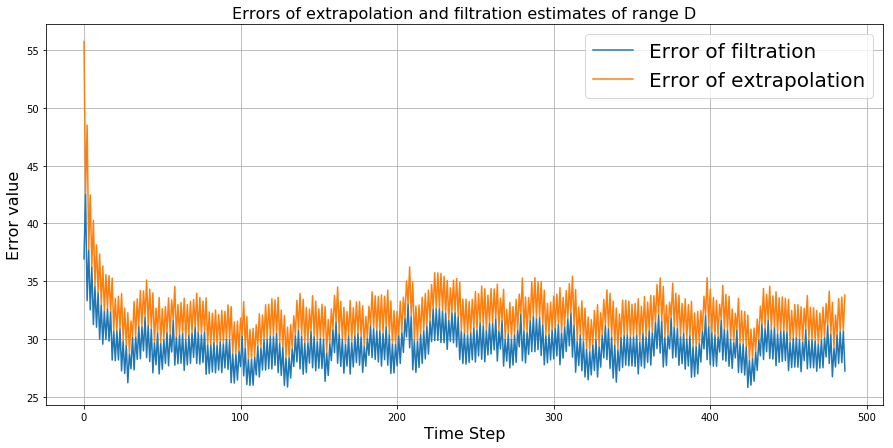

In [23]:
showPlease([fin_mist_D[10:], fin_mist_D_ex[9:]],
           ['Error of filtration', 'Error of extrapolation'],'Time Step','Error value','Errors of extrapolation and filtration estimates of range D')

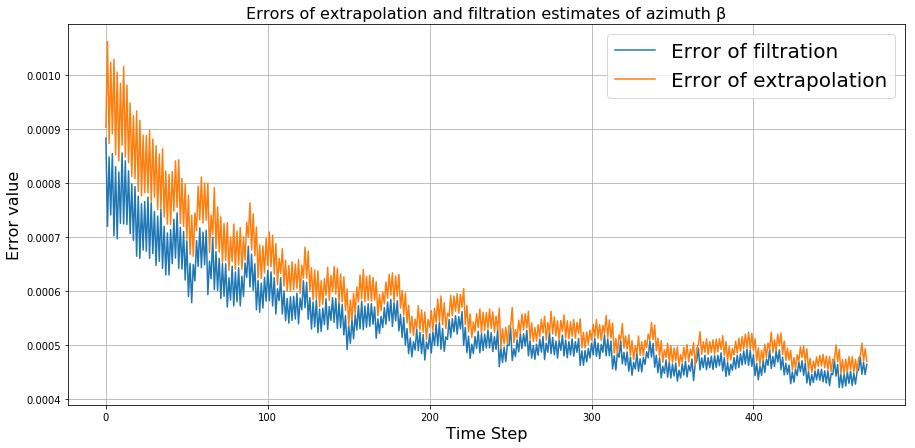

In [24]:
showPlease([fin_mist_β[26:], fin_mist_β_ex[25:]], ['Error of filtration', 'Error of extrapolation'],'Time Step','Error value','Errors of extrapolation and filtration estimates of azimuth β')

**Extrapolation error is slightly greater than filtration one and that tells we've chosen the appropriate algorithm.**

**We can see that the accuracy of prediction and filtration varies between odd and even time steps for both range and azimuth – it increases and decreases (depending on a time step). What is noticable – this process is opposite for prediction and filtration.**


**The second observation of ours: the amplitude of errors of extrapolation and filtration estimates evolves over time steps in a different way for range and azimuth. For 𝛽 errors decrease with time, in the case of range there's persistency area after filter get stabilized. With the help of professor's explanations we explained this with a law of change for data. For range it is close to a linear one, azimuth, on the contrary, changes due to nonlinear law. Thus range can be estimated more accurately. And for azimuth there is a possibility of filter's divergence as its stabilization takes time.**



**Now let's plot and compare obtained true estimation error values with measurement errors of range and azimuth:**


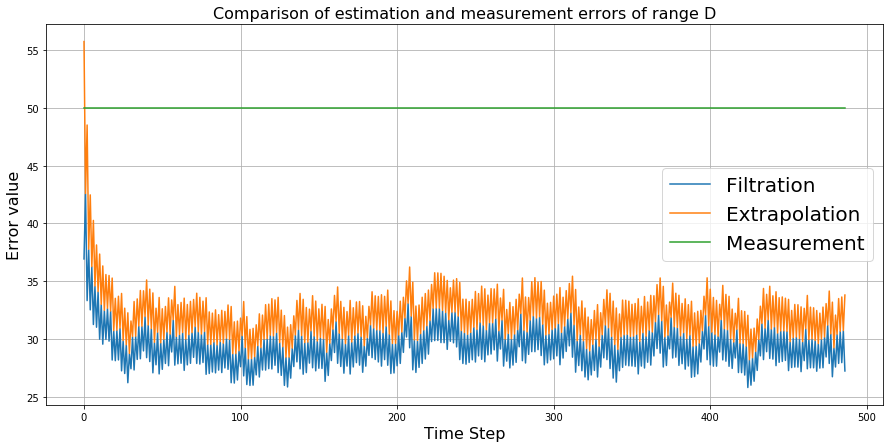

In [25]:
showPlease([fin_mist_D[10:], fin_mist_D_ex[9:], [50] * len(fin_mist_D[10:])],
           ['Filtration', 'Extrapolation', 'Measurement'],'Time Step','Error value','Comparison of estimation and measurement errors of range D')

**We observe that the errors obtained with extended Kalman filter are significantly smaller than measurement ones that were introduced – so the filtering structure is implemented correctly. Again the errors of extrapolated data are through all the processing bigger than filtered one as the algorithm is supposed to perform.**

In [26]:
β_odd = []
β_even = []
for i in range(0,len(fin_mist_β_meas)):
    if(i % 2 != 0):
        β_odd.append(fin_mist_β_meas[i])
    else:
        β_even.append(fin_mist_β_meas[i])

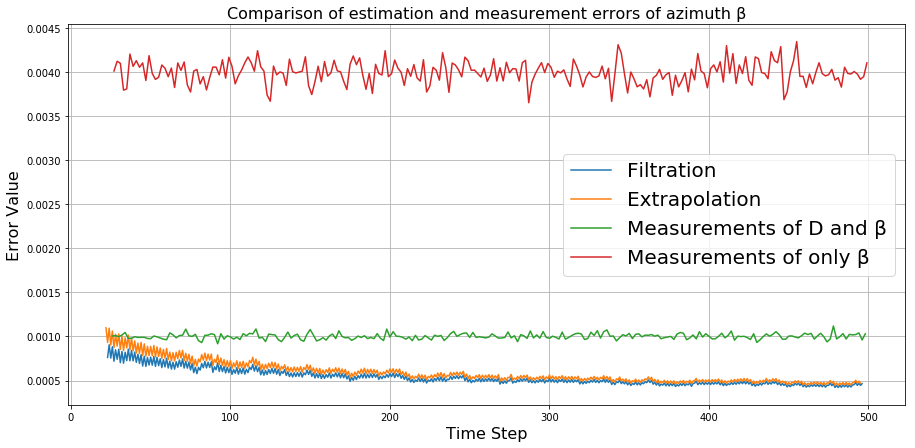

In [33]:
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)
fig, ax = plt.subplots()
shift = 26
#[x for x in range(shift+2,len(fin_mist_β))],
#[x for x in range(shift+2,len(fin_mist_β_ex))],
plt.plot([x for x in range(shift-(len(fin_mist_β_meas) - len(fin_mist_β)),len(fin_mist_β))],fin_mist_β[shift-(len(fin_mist_β_meas) - len(fin_mist_β)):])
plt.plot([x for x in range(shift-(len(fin_mist_β_meas) - len(fin_mist_β_ex)),len(fin_mist_β_ex))],fin_mist_β_ex[shift-(len(fin_mist_β_meas) - len(fin_mist_β_ex)):])
plt.plot([x*2 for x in range(shift//2,250)],β_even[shift//2:])
plt.plot([x*2 + 1 for x in range(shift//2,250)],β_odd[shift//2:])

fig.set_figwidth(15)
fig.set_figheight(7)
plt.grid()
plt.xlabel("Time Step", fontsize = 16)
plt.ylabel("Error Value", fontsize = 16)
plt.legend(['Filtration', 'Extrapolation', 'Measurements of D and β', 'Measurements of only β'])
plt.title("Comparison of estimation and measurement errors of azimuth β", fontsize = 16);
plt.show()

**These visible fluctuations of measurement errors come from obtaining data from 2 sources with significantly different standart deviation we defined. Still, both errors of filtraion and extrapolation estimates are appreciably smaller than the ones of measurement – that demonstrates an appropriate efficiency of developed filter.**

**Conclusion: in this assignment we continued to work on extended Kalman filter dealing with nonlinear measurement models. We've got introduced with a valuable advantage of it (in comparison with the previous method of transforming coordinates) – ability to assimilate information obtained from different time moments. So the core point is about filtering certain measurements depending on a time-step. We added odd-even condition to filtration procedure, extrapolation remained the same as in assignment 11. We've had some issues with filter setup but in the end achieved acceptable results – combined 2 alternating data sources with little estimation errors.**